<h1 align="center">Markov Chain Monte Carlo for fun and profit</h1>
<h1 align="center"> 🎲 ⛓️ 👉 🧪 </h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# This loads some custom styles for matplotlib
import json, matplotlib

with open("assets/matplotlibrc.json") as f:
    matplotlib.rcParams.update(json.load(f))

np.random.seed(
    42
)  # This makes our random numbers reproducable but only when the notebook is run once in order


def show_state(state, ax=None):
    if ax is None:
        f, ax = plt.subplots()
    ax.matshow(state, cmap="Greys", vmin=-1, vmax=1)
    ax.set(xticks=[], yticks=[])

## Making it faster and the dangers of premature optimisation

In order to show you a really big system will still need to make the code a bit faster. Right now we calculate the energy of each state, flip a pixel and then calculate the energy again. It turns out that you can actually directly calculate the energy change instead of doing this subtraction. Let's do this is a sort of test driven decelopment fashion: we want to write a function that when given a state and a pixel to flip, returns how much the energy goes up by (negative if down) upon performing the flip.

I'll first write a slow version of this using the code we already have, and then use that to validate our faster version:

In [2]:
from MCFF.ising_model import energy


def energy_difference_reference_implementation(state, site):
    state = state.copy()
    i, j = site
    energy_before_flip = energy(state)
    state[i, j] *= -1
    energy_after_flip = energy(state)
    return energy_after_flip - energy_before_flip

Now if you stare at the definition of energy long enough, you can convince yourself that the energy change when you flip one pixel only depends on the four surounding pixels in a simple way:

In [3]:
@jit(nopython=True, nogil=True)
def energy_difference(state, site):
    # loop over the four neighbours of the site, skipping if the site is near an edge
    N, M = state.shape
    i, j = site
    h = 0
    for di, dj in [[-1, 0], [1, 0], [0, -1], [0, 1]]:  # loop over N,E,S,W neighbours
        if (0 <= (i + di) < N) and (
            0 <= (j + dj) < M
        ):  # ignore neighbours not in the NxN grid
            h += state[i + di, j + dj]
    return 4 * state[i, j] * h


# do some simple test cases that I can calculate by hand
state = np.ones(
    shape=(3, 3)
)  # a simple 3x3 grid is the smallest one where the center has 4 neighbours
sites = [
    (1, 1),
    (0, 1),
    (0, 0),
]  # Let's try the center, one on an edge and one on a corner

for site in sites:
    reference = 9 * energy_difference_reference_implementation(state, site)
    ours = 9 * energy_difference(state, site)
    print(f"Ref: {reference}, Ours: {ours}")

Ref: 144.0, Ours: 144.0
Ref: 108.0, Ours: 108.0
Ref: 72.0, Ours: 72.0


Ok these simple tests looks good! I was struggling both with the correct factors of two and the sign, so seeing the outputs compared helped a lot. Now let's test against some random data:

In [4]:
N = 50
values = np.array([1, -1], dtype=np.int8)

for _ in range(100):
    random_state = np.random.choice(values, size=(N, N))
    random_site = np.random.randint(N, size=2)
    assert np.allclose(
        energy_difference_reference_implementation(random_state, random_site),
        energy_difference(random_state, random_site),
    )
print("Tests Passed!")

Tests Passed!


Ok great! And this function is much much faster because it only has to look at four pixels rather than all $N^2$ of them!

In [5]:
N = 100
random_state = np.random.choice(values, size=(N, N))
random_site = np.random.randint(N, size=2)

reference = %timeit -n 1000 -o energy_difference_reference_implementation(random_state, random_site)
ours = %timeit -n 1000 -o energy_difference(random_state, random_site)
print(f"{reference.best / ours.best:.0f}x Speedup!")

60.5 µs ± 2.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.15 µs ± 111 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
54x Speedup!


We get a good speedup that increases with N and should be about $N^2$ for very large values of N. Ok so how do we use this? Well we need to rewrite `mcmc` yet again:

In [6]:
@jit(nopython=True, nogil=True)
def old_mcmc_generator(initial_state, steps, T, stepsize=1000, energy=energy):
    N, M = initial_state.shape
    assert N == M

    current_state = initial_state.copy()
    E = N**2 * energy(current_state)
    for _ in range(steps):
        for _ in range(stepsize):
            i, j = np.random.randint(N), np.random.randint(N)

            # modify the state a little, here we just flip a random pixel
            current_state[i, j] *= -1
            new_E = N**2 * energy(current_state)

            if (new_E < E) or np.exp(-(new_E - E) / T) > np.random.random():
                E = new_E
            else:
                current_state[i, j] *= -1  # reject the change we made
        yield current_state.copy()
    return


@jit(nopython=True, nogil=True)
def mcmc_generator(
    initial_state, steps, T, stepsize=1000, energy_difference=energy_difference
):
    N, M = initial_state.shape
    assert N == M

    current_state = initial_state.copy()
    for _ in range(steps):
        for _ in range(stepsize):
            i, j = np.random.randint(N), np.random.randint(N)

            # calculate the energy change if we were to flip this pixel but don't actually do it
            change_in_E = N**2 * energy_difference(current_state, (i, j))

            if change_in_E < 0 or np.exp(-change_in_E / T) > np.random.random():
                current_state[i, j] *= -1  # accept the change!

        yield current_state.copy()
    return


N_steps = 1000
stepsize = 100
N = 100
initial_state = np.ones(shape=(N, N))
old = %timeit -o [_ for s in old_mcmc_generator(initial_state, T = 5, steps = N_steps, stepsize = stepsize)]
new = %timeit -o [_ for s in mcmc_generator(initial_state, T = 5, steps = N_steps, stepsize = stepsize)]
print(f"{old.best / new.best:.0f}x speedup!")

2.57 s ± 25.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
65.2 ms ± 557 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
39x speedup!


We can now comfortably look at much larger systems!

In [7]:
### Simulation Inputs ###
N = 500  # Use an NxN system
steps = 5  # How many times to sample the state
stepsize = (
    5 * N**2
)  # How many individual monte carlo flips to do in between each sample
initial_state = np.random.choice(
    np.array([-1, 1], dtype=np.int8), size=(N, N)
)  # the intial state to use
T = 3.5

### Simulation Code ###
critical_states = [
    s for s in mcmc_generator(initial_state, steps=steps, stepsize=stepsize, T=T)
]

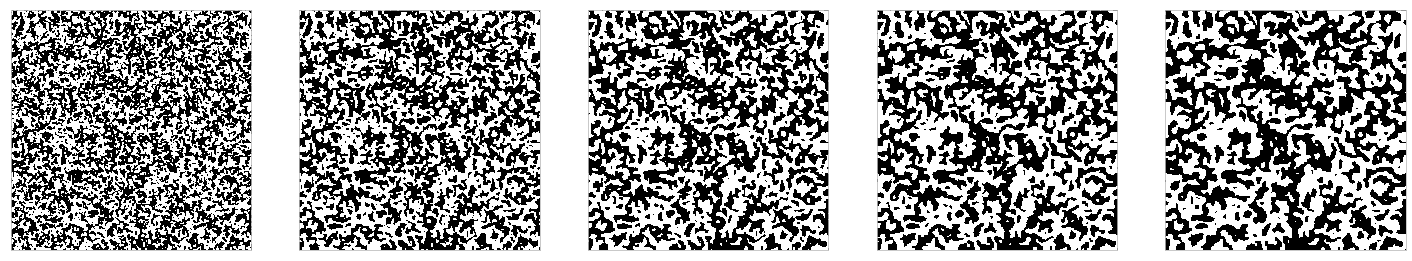

In [8]:
fig, axes = plt.subplots(
    ncols=len(critical_states), figsize=(5 * len(critical_states), 5)
)

for s, ax in zip(critical_states, axes):
    show_state(s, ax=ax)